# Hospitalization length of stay

In this example, we simulate a dataset of 10,000 hospitalized patietns as follows: 

We sample the covariates such that:

$\mbox{Admission Year} \sim \mbox{Uniform}(2000,2014)$

$\mbox{Gender} \sim \mbox{Bernoullie}(0.5), \qquad$ (1 is Female, 0 is Male)

$\mbox{Age} \sim \mbox{Normal}(72+5*\mbox{gender}\;,\;12)$ (years)

$\mbox{Height} \sim \mbox{Normal}(175-5*\mbox{gender}\;,\;7)$ (cm) 

$\mbox{Weight} \sim \mbox{Normal}(\frac{\mbox{height}}{175}*80 - 5 * \mbox{gender} + \frac{\mbox{age}}{20}\;,\;8)$ (kg)

$\mbox{BMI} \: (\mbox{Body} \: \mbox{Mass} \: \mbox{Index}) = \frac{\mbox{Weight}}{(\frac{\mbox{Height}}{100})^2}$ (kg/m^2)

$\mbox{Admission Serial} \sim \mbox{LogNormal}(0, 0.75)$

$\mbox{Smoking Status} \sim \mbox{Multinomial(No, Previously, Currently)} \quad p=[0.5, 0.3, 0.2]$



Precondition features:

$\mbox{General_p} = 0.003 * \mbox{bmi} - 0.15 * \mbox{gender} + 0.002 * \mbox{age} + 0.1 * \mbox{smoking}$

$\mbox{Preconditions_p} = max( min(\mbox{General_p}, 0.65), 0.05)$ 

$\mbox{Hypertension} \sim \mbox{Bernoulli}(\mbox{Preconditions_p})$

$\mbox{Diabetes} \sim \mbox{Bernoulli}(\mbox{Preconditions_p} + 0.003*\mbox{BMI})$

$\mbox{Arterial Fibrillation} \sim \mbox{Bernoulli}(\mbox{Preconditions_p})$

$\mbox{Chronic Obstructive Pulmonary Disease} \sim \mbox{Bernoulli}(\mbox{Preconditions_p} + 0.1*\mbox{smoking})$

$\mbox{Chronic Renal Failure} \sim \mbox{Bernoulli}(\mbox{Preconditions_p})$


Finally, based on the above covariates, we sample LOS and the event type: discharged or in-hospital death.

After sampling the LOS, for some patients we remove weight (and BMI) information based on year of admission, to reflect missingness which can occur in real world data.  

## Loading Simulation Dataset

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 500)
from pydts.examples_utils.simulations_data_config import *
from pydts.examples_utils.datasets import load_LOS_simulated_data
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
data_df = load_LOS_simulated_data()

## Data Description

First, let's look at some descriptive statistics of the columns:

In [3]:
paper_table = data_df.describe().T.round(2)
idx = [r for r in paper_table.index if r not in ['ID', 'Returning_patient', 'Death_date_in_hosp_missing', 
                                                 'In_hospital_death',]]

paper_table = paper_table.loc[idx, :]
paper_table.rename({
    'Age': 'Age (years)',
    'Gender': 'Gender (1 - female)',
    'Admyear': 'Admyear (year)',
    'Firstadm': 'Firstadm (1 - yes)',
    'Admserial': 'Admserial',
    'Weight': 'Weight (kg)',
    'Height': 'Height (cm)',
    'BMI': 'Height (kg/m^2)',
    'Smoking': f"Smoking (0 - never, \\ \qquad \qquad \, 1 - previously, \\ \qquad \qquad \, 2 - currently)",
    'Discharge_relative_date': 'LOS (days)', 
    'Hypertension': 'Hypertension (1 - yes)',
    'Diabities': 'Diabetes (1 - yes)',
    'AF': 'AF (1 - yes)',
    'COPD': 'COPD (1 - yes)',
    'CRF': 'CRF (1 - yes)',
    'Death_relative_date_in_hosp': 'In-Hospital Death (days)'}, inplace=True)
paper_table['count'] = paper_table['count'].astype(int) 

In [4]:
paper_table

count     mean    std  \
Age (years)                                         10000    74.38  12.12   
Gender (1 - female)                                 10000     0.49   0.50   
Admyear (year)                                      10000  2006.96   4.29   
Firstadm (1 - yes)                                  10000     0.70   0.46   
Admserial                                           10000     1.50   1.03   
Weight (kg)                                          4497    80.05   9.40   
Height (cm)                                         10000   172.47   7.41   
Height (kg/m^2)                                      4497    26.94   2.97   
Smoking (0 - never, \ \qquad \qquad \, 1 - prev...  10000     0.70   0.78   
Hypertension (1 - yes)                              10000     0.23   0.42   
Diabetes                                            10000     0.31   0.46   
AF (1 - yes)                                        10000     0.23   0.42   
COPD (1 - yes)                                      10000     0.29   0.46   
CRF (1 - yes)                                       10000     0.23   0.42   
LOS (days)                                          10000    12.96  10.26   
In-Hospital Death (days)                             2362    10.21   7.86   

                                                        min      25%      50%  \
Age (years)                                           24.10    66.30    74.40   
Gender (1 - female)                                    0.00     0.00     0.00   
Admyear (year)                                      2000.00  2003.00  2007.00   
Firstadm (1 - yes)                                     0.00     0.00     1.00   
Admserial                                              1.00     1.00     1.00   
Weight (kg)                                           46.92    73.66    80.08   
Height (cm)                                          145.68   167.50   172.41   
Height (kg/m^2)                                       15.16    24.86    26.89   
Smoking (0 - never, \ \qquad \qquad \, 1 - prev...     0.00     0.00     1.00   
Hypertension (1 - yes)                                 0.00     0.00     0.00   
Diabetes                                               0.00     0.00     0.00   
AF (1 - yes)                                           0.00     0.00     0.00   
COPD (1 - yes)                                         0.00     0.00     0.00   
CRF (1 - yes)                                          0.00     0.00     0.00   
LOS (days)                                             1.00     4.00    10.00   
In-Hospital Death (days)                               1.00     4.00     8.00   

                                                        75%      max  
Age (years)                                           82.60   122.70  
Gender (1 - female)                                    1.00     1.00  
Admyear (year)                                      2011.00  2014.00  
Firstadm (1 - yes)                                     1.00     1.00  
Admserial                                              2.00    17.00  
Weight (kg)                                           86.41   116.46  
Height (cm)                                          177.49   201.24  
Height (kg/m^2)                                       28.85    40.35  
Smoking (0 - never, \ \qquad \qquad \, 1 - prev...     1.00     2.00  
Hypertension (1 - yes)                                 0.00     1.00  
Diabetes                                               1.00     1.00  
AF (1 - yes)                                           0.00     1.00  
COPD (1 - yes)                                         1.00     1.00  
CRF (1 - yes)                                          0.00     1.00  
LOS (days)                                            21.00    31.00  
In-Hospital Death (days)                              15.00    30.00

When dealing with healthcare data, changes of policy can lead to biased data, so it is also a good idea to see how the data looks like with stratification by year of admission:

In [5]:
import tableone as to
columns = [AGE_COL, GENDER_COL, WEIGHT_COL, HEIGHT_COL, BMI_COL, *preconditions, RETURNING_PATIENT_COL]
categorical = [GENDER_COL, *preconditions, RETURNING_PATIENT_COL]
groupby = ADMISSION_YEAR_COL
mytable = to.TableOne(data_df, columns, categorical, groupby)
mytable

Grouped by Admyear                                                                                                                                                                                                                
                                        Missing      Overall       2000.0       2001.0       2002.0       2003.0       2004.0       2005.0       2006.0       2007.0       2008.0       2009.0       2010.0       2011.0       2012.0       2013.0       2014.0
n                                                      10000          637          659          724          657          671          687          661          711          669          678          655          648          631          662          650
Age, mean (SD)                                0  74.4 (12.1)  73.8 (12.4)  74.3 (11.8)  74.7 (12.1)  74.8 (12.0)  74.3 (11.7)  73.9 (11.9)  74.5 (13.1)  73.7 (11.9)  74.8 (12.0)  74.8 (12.1)  75.6 (11.6)  73.8 (12.4)  74.6 (11.9)  73.8 (12.5)  74.2 (12.1)
Gender, n (%)            0.0                  0  5064 (50.6)   307 (48.2)   349 (53.0)   362 (50.0)   317 (48.2)   346 (51.6)   339 (49.3)   350 (53.0)   367 (51.6)   327 (48.9)   355 (52.4)   343 (52.4)   331 (51.1)   318 (50.4)   332 (50.2)   321 (49.4)
                         1.0                     4936 (49.4)   330 (51.8)   310 (47.0)   362 (50.0)   340 (51.8)   325 (48.4)   348 (50.7)   311 (47.0)   344 (48.4)   342 (51.1)   323 (47.6)   312 (47.6)   317 (48.9)   313 (49.6)   330 (49.8)   329 (50.6)
Weight, mean (SD)                          5503   80.1 (9.4)  78.4 (10.5)  80.1 (11.6)   81.2 (9.9)   79.8 (9.7)   78.1 (9.6)   80.0 (9.7)   79.8 (9.2)   80.7 (8.7)   80.9 (9.4)   80.9 (9.4)   79.9 (9.2)   80.4 (9.3)   79.6 (9.4)   79.8 (9.7)   79.8 (8.9)
Height, mean (SD)                             0  172.5 (7.4)  172.7 (7.5)  172.4 (7.8)  172.4 (7.4)  172.4 (7.1)  172.3 (7.3)  172.1 (7.5)  172.5 (7.5)  172.7 (7.2)  172.4 (7.3)  172.9 (7.6)  172.6 (7.5)  172.7 (7.5)  172.3 (7.1)  172.5 (7.7)  172.3 (7.3)
BMI, mean (SD)                             5503   26.9 (3.0)   26.7 (3.4)   27.0 (3.1)   27.0 (3.0)   26.7 (2.9)   26.4 (3.1)   26.9 (3.2)   26.9 (3.0)   27.2 (2.8)   27.2 (3.1)   27.2 (3.0)   26.9 (2.9)   26.9 (3.0)   26.9 (2.9)   26.9 (3.0)   26.9 (2.9)
Smoking, n (%)           0.0                  0  4982 (49.8)   323 (50.7)   349 (53.0)   371 (51.2)   325 (49.5)   332 (49.5)   334 (48.6)   325 (49.2)   352 (49.5)   319 (47.7)   336 (49.6)   310 (47.3)   305 (47.1)   327 (51.8)   322 (48.6)   352 (54.2)
                         1.0                     3033 (30.3)   185 (29.0)   177 (26.9)   228 (31.5)   193 (29.4)   195 (29.1)   220 (32.0)   193 (29.2)   214 (30.1)   221 (33.0)   198 (29.2)   223 (34.0)   211 (32.6)   174 (27.6)   206 (31.1)   195 (30.0)
                         2.0                     1985 (19.9)   129 (20.3)   133 (20.2)   125 (17.3)   139 (21.2)   144 (21.5)   133 (19.4)   143 (21.6)   145 (20.4)   129 (19.3)   144 (21.2)   122 (18.6)   132 (20.4)   130 (20.6)   134 (20.2)   103 (15.8)
Hypertension, n (%)      0.0                  0  7717 (77.2)   505 (79.3)   497 (75.4)   545 (75.3)   523 (79.6)   517 (77.0)   552 (80.3)   482 (72.9)   551 (77.5)   519 (77.6)   520 (76.7)   523 (79.8)   488 (75.3)   478 (75.8)   505 (76.3)   512 (78.8)
                         1.0                     2283 (22.8)   132 (20.7)   162 (24.6)   179 (24.7)   134 (20.4)   154 (23.0)   135 (19.7)   179 (27.1)   160 (22.5)   150 (22.4)   158 (23.3)   132 (20.2)   160 (24.7)   153 (24.2)   157 (23.7)   138 (21.2)
Diabetes, n (%)          0.0                  0  6932 (69.3)   446 (70.0)   444 (67.4)   512 (70.7)   454 (69.1)   457 (68.1)   491 (71.5)   463 (70.0)   491 (69.1)   464 (69.4)   464 (68.4)   444 (67.8)   442 (68.2)   430 (68.1)   453 (68.4)   477 (73.4)
                         1.0                     3068 (30.7)   191 (30.0)   215 (32.6)   212 (29.3)   203 (30.9)   214 (31.9)   196 (28.5)   198 (30.0)   220 (30.9)   205 (30.6)   214 (31.6

Let's visualize the data. With the following figures we can see:

(a) How many patients were hospitalized in total, how many were discharged\died, stratified by year of admission.

(b) Age distributions by sex, males (0) and females (1).

(c) Number of patients at each number of admissions, with a separation to 4 groups.

(d) Kaplan-Meier curves for LOS with and without death as censoring

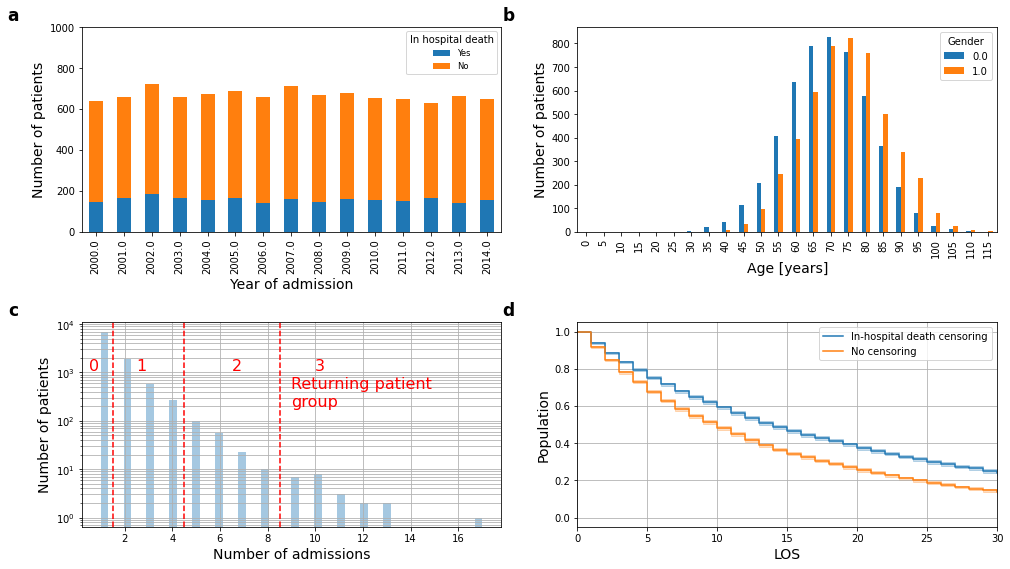

In [21]:
from pydts.examples_utils.plots import *
plot_LOS_simulation_figure1(data_df)

Next, with the following figures we can further visualize the possible outcomes:

(a) Description of the events (death and release).

(b) Distribution of age, by sex, among the patients who died.

(c-d) Number of observed event, by event type. 

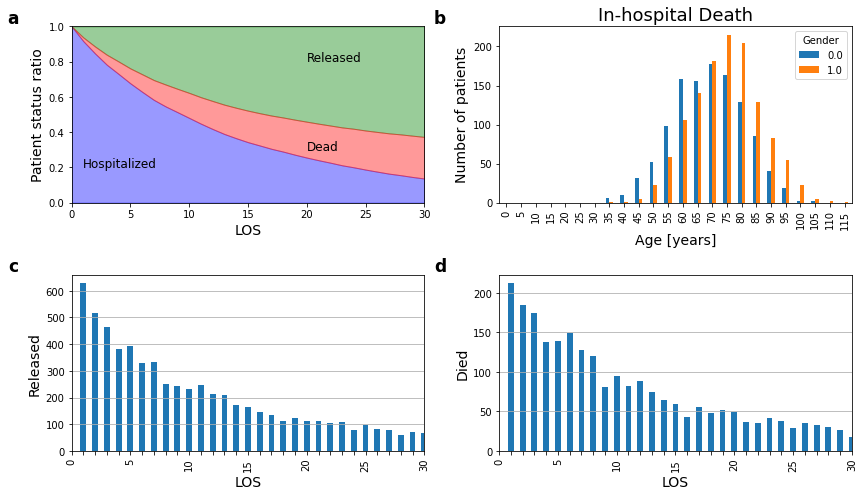

In [7]:
plot_LOS_simulation_figure2(data_df)

and a visualization of the missingness of the weight variable by year of admission:

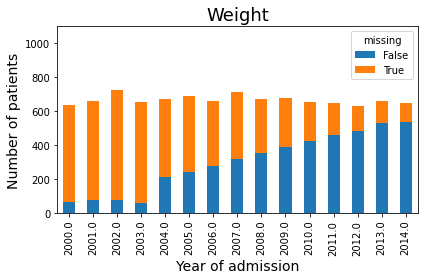

In [8]:
plot_LOS_simulation_figure3(data_df)

# Data Preprocessing

In [9]:
outcome_cols = [
    DISCHARGE_RELATIVE_COL,
    IN_HOSPITAL_DEATH_COL,
    DEATH_RELATIVE_COL, 
    DEATH_MISSING_COL
]

y = data_df.set_index(PATIENT_NO_COL)[outcome_cols]
X = data_df.set_index(PATIENT_NO_COL).drop(columns=outcome_cols)
X.drop([ADMISSION_SERIAL_COL, FIRST_ADMISSION_COL], axis=1, inplace=True)

## Missing Values Imputation

We search for missing data and use median imputation: 

In [10]:
to_impute = X.isna().sum(axis=0).to_frame("value").query("value > 0").index
to_impute

Index(['Weight', 'BMI'], dtype='object')

In [11]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(verbose=1, strategy='median')
X[to_impute] = imputer.fit_transform(X[to_impute])

## Standardization

In some applications it is customize to standardize the covariates, such that each will be with the mean 0 and standard deviation of 1.

For Height, Weight, Age and BMI columns we use Standard scaling, and for Returning Patient and Smoking we use Min-Max scaling:

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

to_normalize = [HEIGHT_COL, WEIGHT_COL, AGE_COL, BMI_COL]
to_minmax = [RETURNING_PATIENT_COL, SMOKING_COL]

std_scaler = StandardScaler() 
X[to_normalize] = std_scaler.fit_transform(X[to_normalize])

minmax_scaler = MinMaxScaler()
X[to_minmax] = minmax_scaler.fit_transform(X[to_minmax])

X.head()

Age  Gender  Admyear    Weight    Height       BMI  Smoking  \
ID                                                                      
0.0 -0.501435     1.0   2001.0  0.001731  0.198481 -0.010699      0.5   
1.0 -1.829968     1.0   2003.0  0.001731  0.255134 -0.010699      0.0   
2.0  0.216468     1.0   2013.0 -0.706832  0.715064 -1.496554      0.0   
3.0  0.356748     1.0   2008.0  0.001731 -0.738724 -0.010699      1.0   
4.0 -0.509686     0.0   2011.0  0.001731 -0.610285 -0.010699      0.5   

     Hypertension  Diabetes   AF  COPD  CRF  Returning_patient  
ID                                                              
0.0           0.0       0.0  0.0   1.0  0.0                0.0  
1.0           0.0       0.0  0.0   0.0  0.0                0.0  
2.0           0.0       0.0  0.0   0.0  0.0                0.0  
3.0           0.0       1.0  1.0   1.0  0.0                0.0  
4.0           1.0       1.0  0.0   0.0  0.0                0.0

Creating event type and event time:

In_hospital_death = 1 means in hospital death (J=1)

In_hospital_death = 0 with Discharge_relative_date <= 30 means a discharge event (J=2)

Discharge_relative_date = 31 means right censored example, i.e. (J=0 at T=30)

In [13]:
y.loc[((y.In_hospital_death == 0) & (y.Discharge_relative_date != 31)), IN_HOSPITAL_DEATH_COL] = 2
y[DISCHARGE_RELATIVE_COL] = y[DISCHARGE_RELATIVE_COL].clip(upper=30).astype(int)
y

Discharge_relative_date  In_hospital_death  \
ID                                                   
0.0                          11                  2   
1.0                          15                  2   
2.0                           6                  2   
3.0                           4                  2   
4.0                           1                  1   
...                         ...                ...   
9995.0                       10                  1   
9996.0                        5                  1   
9997.0                        1                  1   
9998.0                       13                  2   
9999.0                       30                  0   

        Death_relative_date_in_hosp  Death_date_in_hosp_missing  
ID                                                               
0.0                             NaN                           1  
1.0                             NaN                           1  
2.0                             NaN                           1  
3.0                             NaN                           1  
4.0                             1.0                           0  
...                             ...                         ...  
9995.0                         10.0                           0  
9996.0                          5.0                           0  
9997.0                          1.0                           0  
9998.0                          NaN                           1  
9999.0                          NaN                           1  

[10000 rows x 4 columns]

## Estimation

Now we can estimate the parameters of the model using a TwoStagesFitter:

In [14]:
fit_df = pd.concat([X.drop(ADMISSION_YEAR_COL, axis=1), 
                    y[[IN_HOSPITAL_DEATH_COL, DISCHARGE_RELATIVE_COL]]], axis=1).reset_index()
fit_df.head()

ID       Age  Gender    Weight    Height       BMI  Smoking  Hypertension  \
0  0.0 -0.501435     1.0  0.001731  0.198481 -0.010699      0.5           0.0   
1  1.0 -1.829968     1.0  0.001731  0.255134 -0.010699      0.0           0.0   
2  2.0  0.216468     1.0 -0.706832  0.715064 -1.496554      0.0           0.0   
3  3.0  0.356748     1.0  0.001731 -0.738724 -0.010699      1.0           0.0   
4  4.0 -0.509686     0.0  0.001731 -0.610285 -0.010699      0.5           1.0   

   Diabetes   AF  COPD  CRF  Returning_patient  In_hospital_death  \
0       0.0  0.0   1.0  0.0                0.0                  2   
1       0.0  0.0   0.0  0.0                0.0                  2   
2       0.0  0.0   0.0  0.0                0.0                  2   
3       1.0  1.0   1.0  0.0                0.0                  2   
4       1.0  0.0   0.0  0.0                0.0                  1   

   Discharge_relative_date  
0                       11  
1                       15  
2                        6  
3                        4  
4                        1

In [15]:
from pydts.fitters import TwoStagesFitter
fitter = TwoStagesFitter()
fitter.fit(df=fit_df, event_type_col=IN_HOSPITAL_DEATH_COL, duration_col=DISCHARGE_RELATIVE_COL, 
           pid_col=PATIENT_NO_COL)
fitter.print_summary()

j1_params     j1_SE  j2_params     j2_SE
covariate                                                  
Age                 0.012234  0.021289   0.018675  0.013089
Gender              0.072557  0.048761   0.032534  0.029895
Weight             -0.085851  0.039237  -0.096352  0.024137
Height             -0.109585  0.028974  -0.057043  0.017838
BMI                -0.113686  0.038058  -0.069863  0.023324
Smoking             0.006120  0.060227  -0.086379  0.037199
Hypertension       -0.066527  0.052036   0.021493  0.031215
Diabetes            0.045579  0.045944   0.034855  0.028225
AF                  0.042571  0.051099  -0.005837  0.031592
COPD                0.030174  0.049191   0.058040  0.030069
CRF                 0.024396  0.051150   0.039778  0.031179
Returning_patient  -0.097966  0.122227   0.122055  0.073013



Model summary for event: 1


n_jt  success  alpha_jt
In_hospital_death Discharge_relative_date                         
1                 1                         212     True -3.901826
                  2                         184     True -3.950053
                  3                         174     True -3.925112
                  4                         138     True -4.085360
                  5                         139     True -3.992844
                  6                         149     True -3.848771
                  7                         128     True -3.922036
                  8                         120     True -3.908204
                  9                          81     True -4.240269
                  10                         95     True -4.018168
                  11                         82     True -4.095930
                  12                         88     True -3.938631
                  13                         74     True -4.050635
                  14                         65     True -4.108051
                  15                         60     True -4.120188
                  16                         43     True -4.377010
                  17                         56     True -4.067527
                  18                         48     True -4.157987
                  19                         52     True -4.023369
                  20                         49     True -4.016882
                  21                         37     True -4.229897
                  22                         35     True -4.222299
                  23                         42     True -3.979030
                  24                         38     True -4.007955
                  25                         29     True -4.217928
                  26                         36     True -3.923879
                  27                         33     True -3.954917
                  28                         30     True -3.978909
                  29                         27     True -4.023108
                  30                         18     True -4.347235



Model summary for event: 2


n_jt  success  alpha_jt
In_hospital_death Discharge_relative_date                         
2                 1                         628     True -2.755714
                  2                         515     True -2.869952
                  3                         466     True -2.889717
                  4                         383     True -3.012315
                  5                         393     True -2.908478
                  6                         330     True -3.011169
                  7                         332     True -2.923762
                  8                         251     True -3.136989
                  9                         242     True -3.104749
                  10                        232     True -3.082277
                  11                        247     True -2.942857
                  12                        215     True -3.012719
                  13                        209     True -2.966362
                  14                        174     True -3.083501
                  15                        163     True -3.082805
                  16                        145     True -3.138006
                  17                        134     True -3.160356
                  18                        111     True -3.290827
                  19                        123     True -3.127649
                  20                        114     True -3.138881
                  21                        112     True -3.090689
                  22                        105     True -3.093272
                  23                        107     True -3.007764
                  24                         77     True -3.276149
                  25                         99     True -2.956023
                  26                         82     True -3.082226
                  27                         80     True -3.037766
                  28                         59     True -3.280251
                  29                         73     True -2.997231
                  30                         69     True -2.985297

In [16]:
fitter.get_beta_SE()

j1_params     j1_SE  j2_params     j2_SE
covariate                                                  
Age                 0.012234  0.021289   0.018675  0.013089
Gender              0.072557  0.048761   0.032534  0.029895
Weight             -0.085851  0.039237  -0.096352  0.024137
Height             -0.109585  0.028974  -0.057043  0.017838
BMI                -0.113686  0.038058  -0.069863  0.023324
Smoking             0.006120  0.060227  -0.086379  0.037199
Hypertension       -0.066527  0.052036   0.021493  0.031215
Diabetes            0.045579  0.045944   0.034855  0.028225
AF                  0.042571  0.051099  -0.005837  0.031592
COPD                0.030174  0.049191   0.058040  0.030069
CRF                 0.024396  0.051150   0.039778  0.031179
Returning_patient  -0.097966  0.122227   0.122055  0.073013

In [17]:
from pydts.examples_utils.plots import add_panel_text

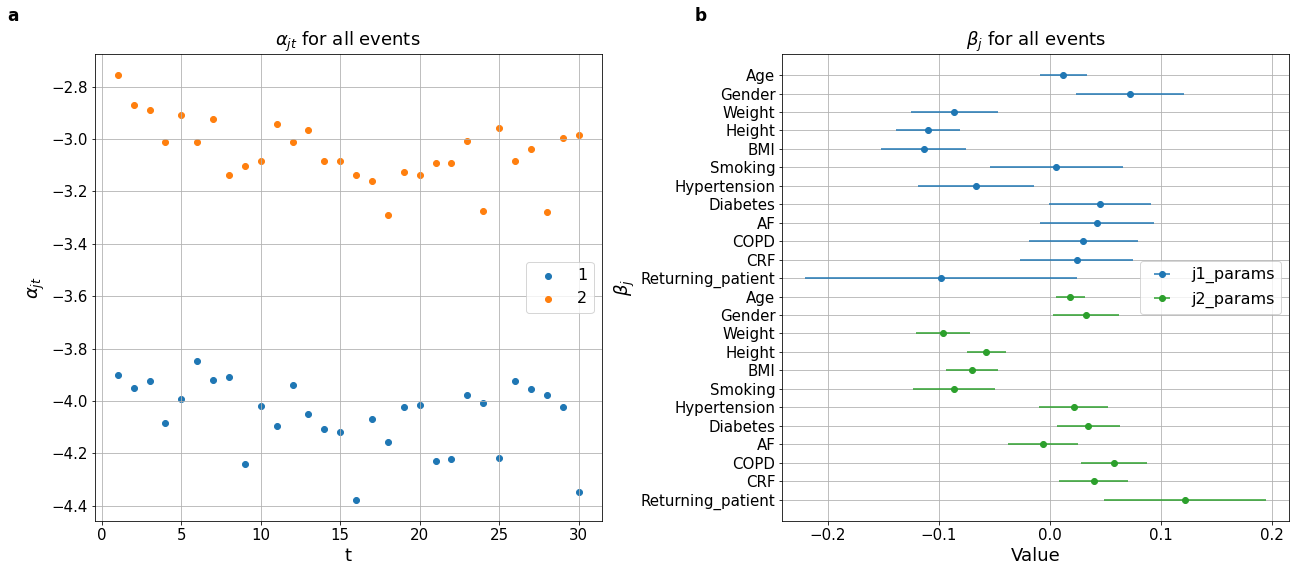

In [18]:
fig, axes = plt.subplots(1,2, figsize=(18,8))
ax = axes[0]
fitter.plot_all_events_alpha(ax=ax, show=False)
ax.grid()
ax.legend(fontsize=16, loc='center right')
add_panel_text(ax, 'a')
ax = axes[1]
fitter.plot_all_events_beta(ax=ax, show=False, xlabel='Value')
ax.legend(fontsize=16, loc='center right')
add_panel_text(ax, 'b')
fig.tight_layout()

## Prediction

In [19]:
pred_df = fitter.predict_cumulative_incident_function(fit_df.iloc[2:5]).T
pred_df = pred_df.iloc[1:]
pred_df.columns = ['ID=2', 'ID=3', 'ID=4']
pred_df.head()

ID=2      ID=3      ID=4
Age     0.216468  0.356748 -0.509686
Gender  1.000000  1.000000  0.000000
Weight -0.706832  0.001731  0.001731
Height  0.715064 -0.738724 -0.610285
BMI    -1.496554 -0.010699 -0.010699

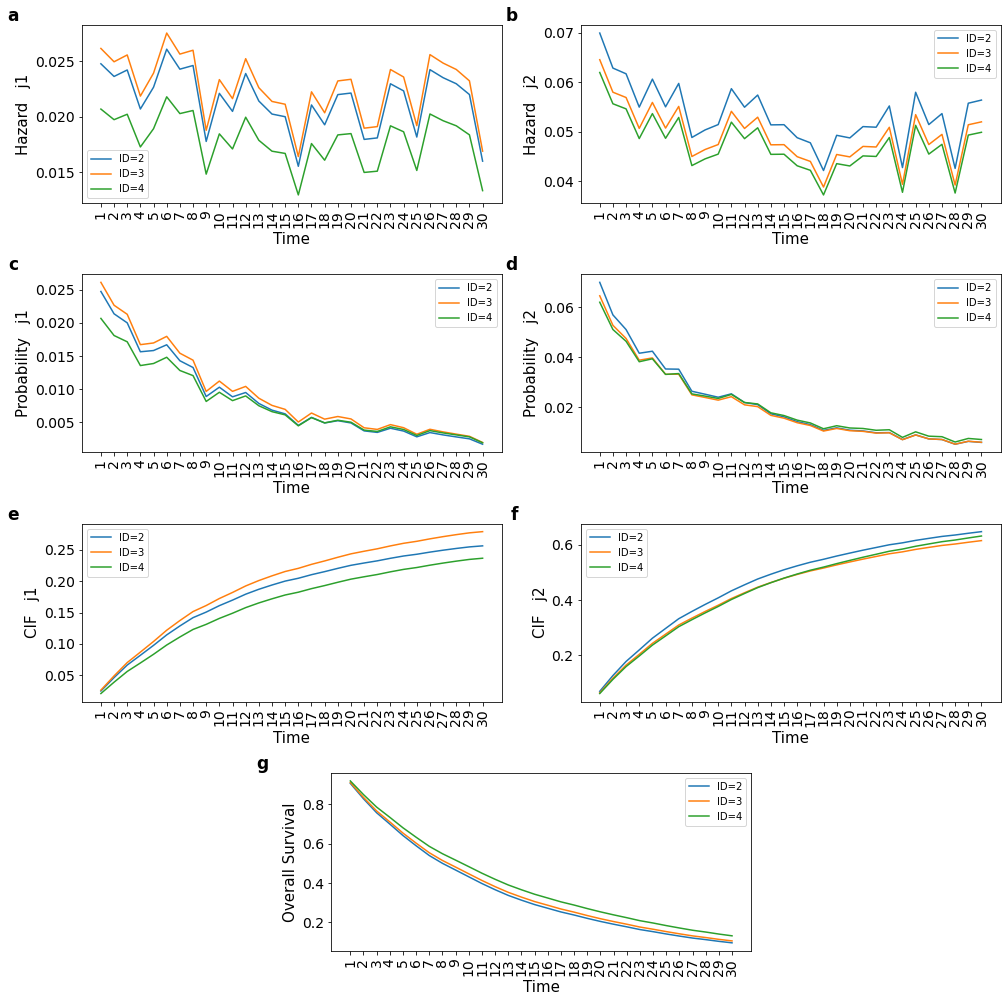

In [20]:
plot_example_pred_output(pred_df)